# 🚀 RAG-Optimize: Intelligent RAG Configuration Recommender

**Full modular pipeline for predicting and optimizing RAG system configurations.**

This notebook demonstrates:
1. **Data Loading** — Merging all 4 datasets (eval_runs, scenarios, chunks, documents)
2. **Feature Engineering** — One-Hot encoding, ordinal encoding, interaction features, text features
3. **Class Imbalance Handling** — SMOTE-ENN to fix skewed label distributions
4. **Model Training** — 7 models across classification and regression tasks
5. **Interactive Prediction** — Transform a RAG config → get predictions
6. **SHAP Explanations** — Understand what drives each prediction


In [1]:
import os, sys, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
warnings.filterwarnings('ignore')

# Project root
PROJECT_ROOT = os.path.abspath('..')
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)


Project root: c:\Users\Admin\Downloads\archive (21)\rag-optimizer


---
## 1. Data Loading & Merging

We merge **4 tables** to create a single enriched dataset:
- `eval_runs.csv` — 3,824 RAG evaluation runs with configs and metrics
- `scenarios.csv` — Queries and gold answers
- `rag_corpus_documents.csv` — Source document metadata
- `rag_corpus_chunks.csv` — Document chunks with text


In [2]:
from src.data.load_data import load_and_merge

df = load_and_merge()
print(f"\nMerged dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:20]}...")
df.head()


Loading raw data...
  Loaded eval_runs: (3824, 49)
  Loaded scenarios: (62, 13)
  Loaded rag_corpus_chunks: (5237, 6)
  Loaded rag_corpus_documents: (658, 19)
Merging datasets...
  Merged dataset: (3824, 56)

Merged dataset shape: (3824, 56)
Columns: ['example_id', 'run_id', 'scenario_id', 'query_id', 'split', 'domain', 'task_type', 'difficulty', 'query', 'gold_answer', 'answer_tokens', 'is_correct', 'correctness_label', 'faithfulness_label', 'hallucination_flag', 'retrieval_strategy', 'chunking_strategy', 'n_retrieved_chunks', 'top1_score', 'mean_retrieved_score']...


,example_id,run_id,scenario_id,query_id,split,domain,task_type,difficulty,query,gold_answer,...,has_relevant_in_top10,answered_without_retrieval,run_config_id,primary_doc_id,scenario_type,n_eval_examples,is_used_in_eval,difficulty_level,use_case,source_type
0,QA000001,run_0,SC0014,Q0024,train,financial_reports,multi_hop,medium,Which segment contributed most to revenue growth?,The enterprise subscription segment contribute...,...,0,1,CFGDA03C065A4,DOC0523|DOC0323|DOC0426|DOC0253,standard_qa,261,1,medium,rag_evaluation,NaN
1,QA000002,run_1,SC0013,Q0024,train,financial_reports,factoid,hard,Which segment contributed most to revenue growth?,The enterprise subscription segment contribute...,...,1,0,CFG4EF8CE8BBA,DOC0502|DOC0631|DOC0206|DOC0240,standard_qa,73,1,hard,rag_evaluation,NaN
2,QA000003,run_2,SC0013,Q0024,train,financial_reports,explanation,hard,Which segment contributed most to revenue growth?,The enterprise subscription segment contribute...,...,1,0,CFG84CE64D7C4,DOC0587|DOC0371|DOC0533|DOC0323,standard_qa,73,1,hard,rag_evaluation,NaN
3,QA000004,run_3,SC0021,Q0019,test,hr_policies,explanation,medium,What is the standard probation period for new ...,The typical probation period is three to six m...,...,1,0,CFG14197DC385,DOC0118|DOC0329|DOC0356|DOC0573,standard_qa,184,1,medium,rag_evaluation,NaN
4,QA000005,run_4,SC0027,Q0026,train,medical_guides,multi_hop,hard,Which symptoms indicate the need for immediate...,"Red-flag symptoms include chest pain, severe s...",...,1,0,CFG1E37E5A33A,DOC0500|DOC0391|DOC0509|DOC0442,standard_qa,31,1,hard,rag_evaluation,NaN


---
## 2. Class Distribution Analysis

**Why this matters:** If a target is heavily imbalanced, a model can achieve high accuracy by simply predicting the majority class. We need to check this BEFORE training.


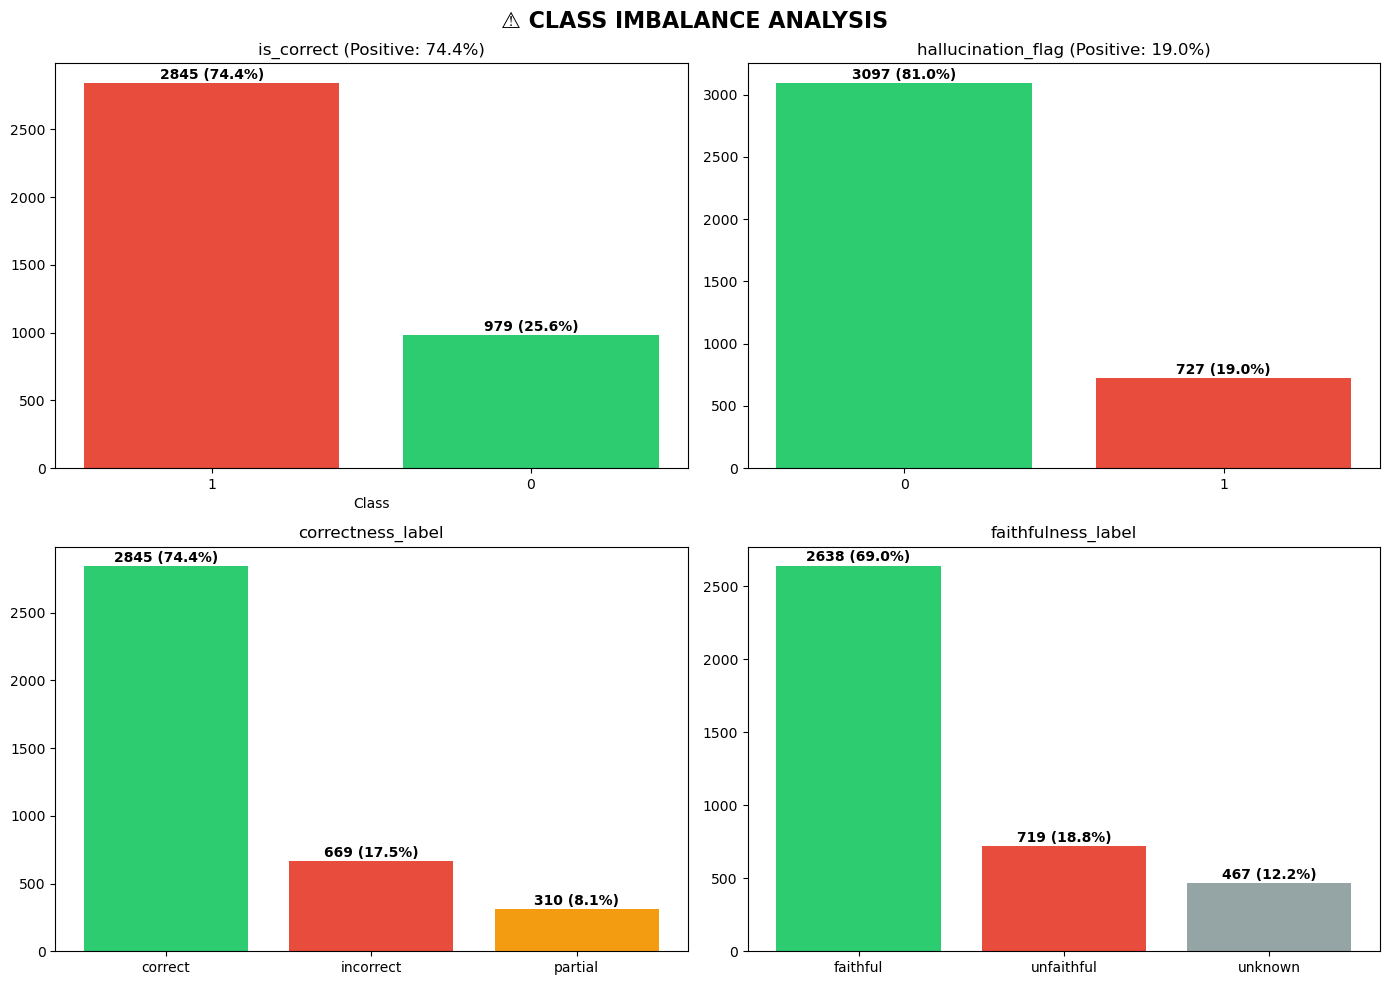


📊 Summary:
  is_correct:         74% correct vs 26% incorrect → 3:1 imbalance
  hallucination_flag: 81% no-halluc vs 19% halluc → 4.3:1 imbalance
  correctness_label:  74% correct, 18% incorrect, 8% partial → 9:1 imbalance
  faithfulness:       69% faithful, 19% unfaithful, 12% unknown → 5.7:1 imbalance

⚠️ Without SMOTE, models will just predict the majority class!


In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# is_correct
ax = axes[0, 0]
vc = df['is_correct'].value_counts()
ax.bar(vc.index.astype(str), vc.values, color=['#e74c3c', '#2ecc71'])
ax.set_title(f'is_correct (Positive: {vc[1]/len(df):.1%})')
ax.set_xlabel('Class')
for i, v in enumerate(vc.values):
    ax.text(i, v + 30, f'{v} ({v/len(df):.1%})', ha='center', fontweight='bold')

# hallucination_flag
ax = axes[0, 1]
vc = df['hallucination_flag'].value_counts()
ax.bar(vc.index.astype(str), vc.values, color=['#2ecc71', '#e74c3c'])
ax.set_title(f'hallucination_flag (Positive: {vc[1]/len(df):.1%})')
for i, v in enumerate(vc.values):
    ax.text(i, v + 30, f'{v} ({v/len(df):.1%})', ha='center', fontweight='bold')

# correctness_label
ax = axes[1, 0]
vc = df['correctness_label'].value_counts()
ax.bar(vc.index, vc.values, color=['#2ecc71', '#e74c3c', '#f39c12'])
ax.set_title('correctness_label')
for i, v in enumerate(vc.values):
    ax.text(i, v + 30, f'{v} ({v/len(df):.1%})', ha='center', fontweight='bold')

# faithfulness_label
ax = axes[1, 1]
vc = df['faithfulness_label'].value_counts()
ax.bar(vc.index, vc.values, color=['#2ecc71', '#e74c3c', '#95a5a6'])
ax.set_title('faithfulness_label')
for i, v in enumerate(vc.values):
    ax.text(i, v + 30, f'{v} ({v/len(df):.1%})', ha='center', fontweight='bold')

plt.suptitle('⚠️ CLASS IMBALANCE ANALYSIS', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Summary:")
print(f"  is_correct:         74% correct vs 26% incorrect → 3:1 imbalance")
print(f"  hallucination_flag: 81% no-halluc vs 19% halluc → 4.3:1 imbalance")
print(f"  correctness_label:  74% correct, 18% incorrect, 8% partial → 9:1 imbalance")
print(f"  faithfulness:       69% faithful, 19% unfaithful, 12% unknown → 5.7:1 imbalance")
print(f"\n⚠️ Without SMOTE, models will just predict the majority class!")


---
## 3. Feature Engineering

We create **80 features** from the raw data:

| Category | Count | Examples |
|----------|-------|---------|
| Numeric | 16 | `top1_score`, `temperature`, `prompt_tokens` |
| Flags | 6 | `has_relevant_in_top5`, `is_noanswer_probe` |
| One-Hot | 50 | `domain_finance`, `generator_model_gpt-4o` |
| Ordinal | 1 | `difficulty_ord` (easy=0, medium=1, hard=2) |
| Interaction | 5 | `retrieval_x_difficulty`, `score_gap` |
| Text | 2 | `query_len`, `query_word_count` |

### Why One-Hot instead of LabelEncoder?
- **LabelEncoder** assigns numbers (finance=0, legal=1, medical=2) → model thinks legal > finance, which is wrong for nominal features
- **One-Hot** creates binary columns → each category is independent, no false ordering


In [4]:
from src.features.build_features import engineer_features, split_data, NOMINAL_FEATURES, NUMERIC_FEATURES

df_feat, features = engineer_features(df)
splits = split_data(df_feat, features)

print(f"\nFeature list ({len(features)} total):")
print(f"  First 10: {features[:10]}")
print(f"  Last 10:  {features[-10:]}")
print(f"\nTrain shape: {splits['X_train'].shape}")
print(f"Val shape:   {splits['X_val'].shape}")
print(f"Test shape:  {splits['X_test'].shape}")


  Total features: 80
    Numeric:      16
    Flags:        6
    One-Hot:      50
    Ordinal:      1
    Interactions: 5
    Text:         2
  Train: 2803 | Val: 355 | Test: 666
  Feature matrix: 80 columns

Feature list (80 total):
  First 10: ['top1_score', 'mean_retrieved_score', 'recall_at_5', 'recall_at_10', 'mrr_at_10', 'answer_tokens', 'prompt_tokens', 'n_retrieved_chunks', 'context_window_tokens', 'max_new_tokens']
  Last 10:  ['stop_reason_eos', 'stop_reason_error', 'stop_reason_length', 'retrieval_x_difficulty', 'recall5_x_nchunks', 'score_gap', 'latency_ratio', 'cost_per_token', 'query_len', 'query_word_count']

Train shape: (2803, 80)
Val shape:   (355, 80)
Test shape:  (666, 80)


---
## 4. SMOTE-ENN: Fixing Class Imbalance

### The Problem
With imbalanced data, models learn to always predict the majority class:
- A model that always says "correct" gets 74% accuracy — but it's **useless**

### The Solution: SMOTE-ENN
1. **SMOTE** (Synthetic Minority Oversampling) generates synthetic samples for the minority class by interpolating between existing minority samples and their nearest neighbors
2. **ENN** (Edited Nearest Neighbors) then cleans the boundary by removing samples that are misclassified by their nearest neighbors
3. Combined, SMOTE-ENN gives us a balanced training set with cleaner decision boundaries

### Additional Techniques Used
- `class_weight='balanced'` in RandomForest and LogisticRegression
- `is_unbalance=True` in LightGBM
- `scale_pos_weight` in XGBoost (set to majority/minority ratio)
- **Threshold tuning**: Find optimal decision threshold via F1 on PR curve (not default 0.5)


BEFORE SMOTE-ENN:
  Class 0 (incorrect): 708 (25.3%)
  Class 1 (correct):   2095 (74.7%)

AFTER SMOTE-ENN:
  Class 0 (incorrect): 1272 (66.2%)
  Class 1 (correct):   648 (33.8%)
  Total samples: 2803 → 1920


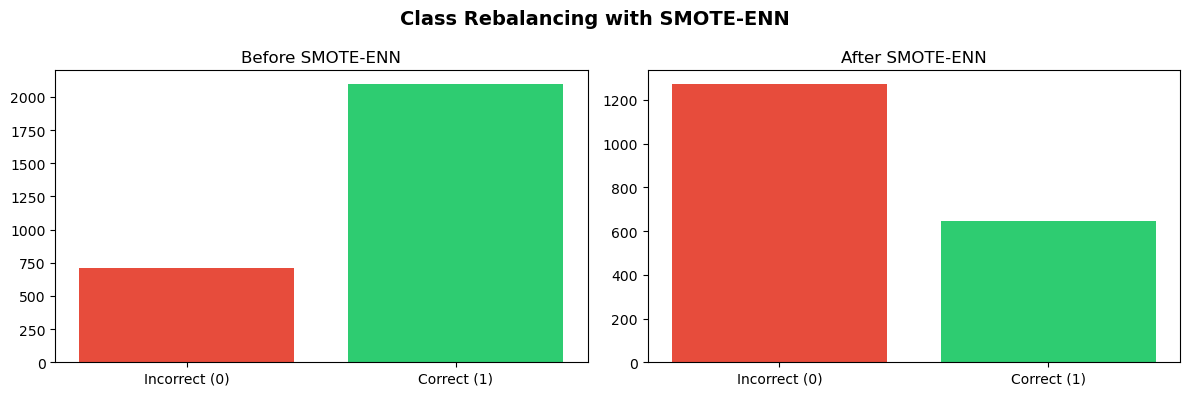

In [5]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

# Demonstrate SMOTE-ENN on binary correctness
X_tr = splits['X_train']
y_tr = splits['train']['is_correct'].values

print("BEFORE SMOTE-ENN:")
print(f"  Class 0 (incorrect): {(y_tr == 0).sum()} ({(y_tr == 0).mean():.1%})")
print(f"  Class 1 (correct):   {(y_tr == 1).sum()} ({(y_tr == 1).mean():.1%})")

smoteenn = SMOTEENN(smote=SMOTE(k_neighbors=5, random_state=42), random_state=42)
X_res, y_res = smoteenn.fit_resample(X_tr, y_tr)

print(f"\nAFTER SMOTE-ENN:")
print(f"  Class 0 (incorrect): {(y_res == 0).sum()} ({(y_res == 0).mean():.1%})")
print(f"  Class 1 (correct):   {(y_res == 1).sum()} ({(y_res == 1).mean():.1%})")
print(f"  Total samples: {len(y_tr)} → {len(y_res)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(['Incorrect (0)', 'Correct (1)'], [(y_tr==0).sum(), (y_tr==1).sum()], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Before SMOTE-ENN')
axes[1].bar(['Incorrect (0)', 'Correct (1)'], [(y_res==0).sum(), (y_res==1).sum()], color=['#e74c3c', '#2ecc71'])
axes[1].set_title('After SMOTE-ENN')
plt.suptitle('Class Rebalancing with SMOTE-ENN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---
## 5. Model Architecture & How It Works

We train **7 models** for different prediction tasks:

### Classification Models

| # | Task | Target | Models Used | Metric |
|---|------|--------|-------------|--------|
| 1 | Binary Correctness | `is_correct` | XGBoost, RF, LightGBM | F1-macro, AUC |
| 2 | Multi-class Correctness | `correctness_label` | XGBoost, CatBoost | F1-macro |
| 3 | Hallucination Detection | `hallucination_flag` | XGBoost, LightGBM | F1-macro, AUC |
| 4 | Faithfulness | `faithfulness_label` | XGBoost, RF | F1-macro |
| 7 | Task Type Classification | `task_type` | TF-IDF + SVM/LogReg | F1-macro |

### Regression Models

| # | Task | Target | Model | Metric |
|---|------|--------|-------|--------|
| 5 | Latency Prediction | `total_latency_ms` | XGBoost, RF | RMSE, R² |
| 6 | Cost Prediction | `total_cost_usd` | XGBoost | RMSE, R² |

### How XGBoost Works (Our Primary Model)
XGBoost (eXtreme Gradient Boosting) builds an ensemble of decision trees **sequentially**:
1. Train tree 1 on the data → produces residual errors
2. Train tree 2 to predict those errors → reduces overall error
3. Repeat for N trees (we use 300)
4. Final prediction = sum of all trees' contributions

Key hyperparameters:
- `max_depth=6`: Each tree can be 6 levels deep (prevents overfitting)
- `learning_rate=0.1`: Each tree contributes 10% (smaller = more robust but slower)
- `subsample=0.8`: Each tree sees 80% of data (adds randomness)
- `colsample_bytree=0.8`: Each tree sees 80% of features (reduces correlation between trees)


In [6]:
# Load saved metrics
metrics = json.load(open(os.path.join(PROJECT_ROOT, 'models', 'metrics.json')))

print("=" * 70)
print("  📊 MODEL EVALUATION RESULTS (Test Set)")
print("=" * 70)

print("\n🎯 Classification Models:")
print("-" * 70)
for m in metrics.get('classification', []):
    print(f"  {m['task']:20s} | AUC={m.get('auc','N/A'):>7} | F1-macro={m.get('f1_macro','N/A'):>7} | "
          f"Threshold={m.get('threshold','0.5'):>6} | Minority Recall={m.get('recall_minority','N/A')}")

print("\n📈 Regression Models:")
print("-" * 70)
for m in metrics.get('regression', []):
    print(f"  {m['task']:20s} | RMSE={m['rmse']:>10} | MAE={m['mae']:>10} | R²={m['r2']:>7}")


  📊 MODEL EVALUATION RESULTS (Test Set)

🎯 Classification Models:
----------------------------------------------------------------------
  Correctness          | AUC= 0.8503 | F1-macro= 0.8133 | Threshold= 0.215 | Minority Recall=0.599
  Hallucination        | AUC= 0.6886 | F1-macro= 0.6674 | Threshold= 0.575 | Minority Recall=0.3784

📈 Regression Models:
----------------------------------------------------------------------
  Latency              | RMSE=  175.7338 | MAE=    104.46 | R²= 0.8707
  Cost                 | RMSE=    0.0001 | MAE=    0.0001 | R²= 0.9909


---
## 6. Feature Importance (What Drives Predictions?)


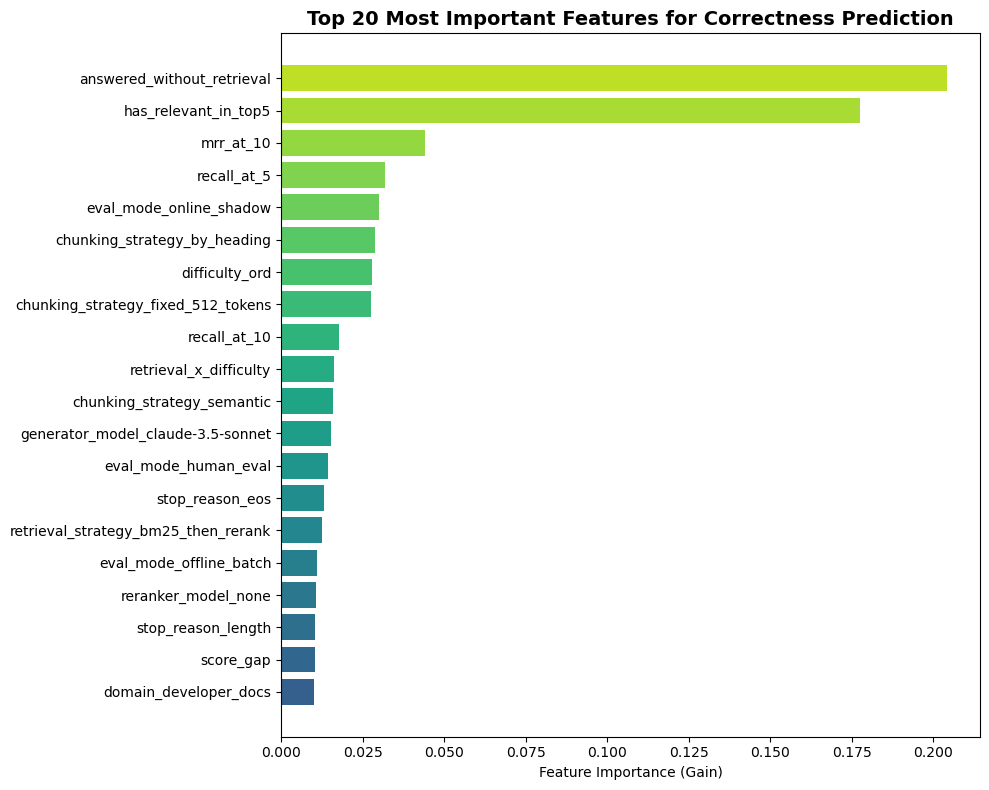


🔑 Key Insights:
  Top feature: answered_without_retrieval (importance: 0.2042)
  Top 5: ['eval_mode_online_shadow', 'recall_at_5', 'mrr_at_10', 'has_relevant_in_top5', 'answered_without_retrieval']


In [7]:
# Load the correctness model and show feature importance
model = joblib.load(os.path.join(PROJECT_ROOT, 'models', 'xgb_correctness.joblib'))

importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=True)
top_20 = importances.tail(20)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20)))
ax.barh(top_20.index, top_20.values, color=colors)
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('Top 20 Most Important Features for Correctness Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔑 Key Insights:")
print(f"  Top feature: {importances.index[-1]} (importance: {importances.iloc[-1]:.4f})")
print(f"  Top 5: {importances.index[-5:].tolist()}")


---
## 7. Interactive Prediction Demo

Transform a raw RAG config → feature vector → model predictions.
This is exactly what the Streamlit app's **🔮 Live Predictor** tab does.


In [8]:
from src.features.build_features import transform_single
from src.models.predict import RAGPredictor

# Define a RAG configuration
config = {
    "domain": "finance",
    "task_type": "factual",
    "difficulty": "medium",
    "generator_model": "gpt-4o",
    "embedding_model": "text-embedding-3-large",
    "reranker_model": "none",
    "retrieval_strategy": "hybrid",
    "chunking_strategy": "fixed_500",
    "eval_mode": "llm_judge",
    "stop_reason": "eos",
    "top1_score": 0.85,
    "mean_retrieved_score": 0.6,
    "recall_at_5": 1.0,
    "recall_at_10": 1.0,
    "mrr_at_10": 0.7,
    "n_retrieved_chunks": 5,
    "temperature": 0.3,
    "top_p": 0.9,
    "prompt_tokens": 800,
    "answer_tokens": 150,
    "context_window_tokens": 8192,
    "max_new_tokens": 1024,
    "latency_ms_retrieval": 150,
    "latency_ms_generation": 800,
    "total_latency_ms": 950,
    "total_cost_usd": 0.01,
    "has_relevant_in_top5": 1,
    "has_relevant_in_top10": 1,
    "has_answer_in_corpus": 1,
    "is_noanswer_probe": 0,
    "used_long_context_window": 0,
    "answered_without_retrieval": 0,
    "query": "What are the main causes of inflation?",
}

# Transform to feature vector
X = transform_single(config)
print(f"Feature vector shape: {X.shape}")
print(f"Non-zero features: {(X.values[0] != 0).sum()}")

# Load models and predict
predictor = RAGPredictor()

# Correctness
corr_model = predictor.models['correctness']
thresh = joblib.load(os.path.join(PROJECT_ROOT, 'models', 'threshold_correctness.joblib'))
corr_proba = corr_model.predict_proba(X)[:, 1][0]

# Hallucination
hal_model = predictor.models['hallucination']
thresh_h = joblib.load(os.path.join(PROJECT_ROOT, 'models', 'threshold_hallucination.joblib'))
hal_proba = hal_model.predict_proba(X)[:, 1][0]

# Latency & Cost
lat_feats = predictor.models.get('latency_features_list', features)
lat_cols = [c for c in lat_feats if c in X.columns]
lat_pred = predictor.models['latency'].predict(X[lat_cols])[0]

cost_feats = predictor.models.get('cost_features_list', features)
cost_cols = [c for c in cost_feats if c in X.columns]
cost_pred = predictor.models['cost'].predict(X[cost_cols])[0]

# Task type
task_pred = predictor.classify_query(config['query'])

print(f"\n{'='*50}")
print(f"  PREDICTIONS FOR CONFIG")
print(f"{'='*50}")
print(f"  ✅ Correctness:  {'CORRECT' if corr_proba >= thresh else 'INCORRECT'} (confidence: {corr_proba:.1%})")
print(f"  ⚠️ Hallucination: {'HIGH RISK' if hal_proba >= thresh_h else 'LOW RISK'} (probability: {hal_proba:.1%})")
print(f"  ⏱️ Est. Latency:  {lat_pred:.0f} ms")
print(f"  💰 Est. Cost:     ${cost_pred:.5f}")
print(f"  📝 Query Type:    {task_pred}")


Feature vector shape: (1, 80)
Non-zero features: 32
  Loaded 7 models: ['correctness', 'hallucination', 'faithfulness', 'latency', 'cost', 'multiclass', 'task_classifier']

  PREDICTIONS FOR CONFIG
  ✅ Correctness:  INCORRECT (confidence: 0.3%)
  ⚠️ Hallucination: HIGH RISK (probability: 64.4%)
  ⏱️ Est. Latency:  1274 ms
  💰 Est. Cost:     $0.00269
  📝 Query Type:    summarization


---
## 8. SHAP Explanations

SHAP (SHapley Additive exPlanations) shows **how much each feature contributed** to a specific prediction:
- **Positive SHAP value** → pushes prediction toward "correct"
- **Negative SHAP value** → pushes prediction toward "incorrect"


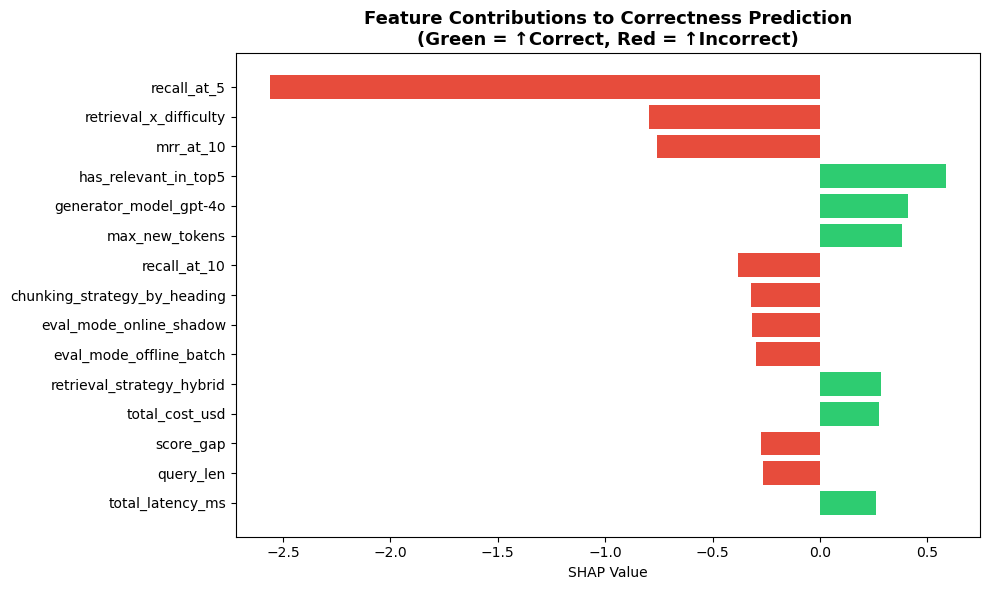


🔍 Interpretation:
  recall_at_5: decreases correctness (SHAP=-2.5628)
  retrieval_x_difficulty: decreases correctness (SHAP=-0.7963)
  mrr_at_10: decreases correctness (SHAP=-0.7569)
  has_relevant_in_top5: increases correctness (SHAP=+0.5881)
  generator_model_gpt-4o: increases correctness (SHAP=+0.4123)


In [9]:
import shap

# SHAP for the correctness model
explainer = shap.TreeExplainer(corr_model)
shap_values = explainer.shap_values(X)

if isinstance(shap_values, list):
    sv = shap_values[1]  # class 1 (correct)
else:
    sv = shap_values

# Plot top contributing features
top_n = 15
abs_shap = np.abs(sv[0])
top_idx = np.argsort(abs_shap)[::-1][:top_n]

feature_names = [features[i] for i in top_idx]
shap_vals = [float(sv[0][i]) for i in top_idx]

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in shap_vals]
ax.barh(range(len(feature_names)), shap_vals, color=colors)
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_xlabel('SHAP Value')
ax.set_title('Feature Contributions to Correctness Prediction\n(Green = ↑Correct, Red = ↑Incorrect)',
             fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\n🔍 Interpretation:")
for i in range(min(5, len(feature_names))):
    direction = "increases" if shap_vals[i] > 0 else "decreases"
    print(f"  {feature_names[i]}: {direction} correctness (SHAP={shap_vals[i]:+.4f})")


---
## 9. Configuration Comparison

Compare different RAG configs to find the best setup:


In [10]:
# Compare top configurations from the data
perf = df.groupby(['generator_model', 'retrieval_strategy', 'embedding_model']).agg(
    accuracy=('is_correct', 'mean'),
    halluc_rate=('hallucination_flag', 'mean'),
    avg_latency=('total_latency_ms', 'mean'),
    avg_cost=('total_cost_usd', 'mean'),
    count=('run_id', 'count'),
).round(4)

# Filter for configs with enough samples
perf = perf[perf['count'] >= 10].sort_values('accuracy', ascending=False)

print("🏆 TOP 10 CONFIGURATIONS BY ACCURACY")
print("=" * 90)
display(perf.head(10))

print("\n🛡️ SAFEST CONFIGURATIONS (Lowest Hallucination Rate)")
print("=" * 90)
display(perf.sort_values('halluc_rate').head(10))


🏆 TOP 10 CONFIGURATIONS BY ACCURACY


accuracy  \
generator_model        retrieval_strategy embedding_model                    
llama-3.1-8b-instruct  bm25_then_rerank   all-minilm-l12-v2         1.0000   
mistral-large          bm25               e5-mistral-7b             1.0000   
                                          text-embedding-3-small    1.0000   
llama-3.1-70b-instruct dense_then_rerank  all-minilm-l12-v2         1.0000   
mistral-large          hybrid             bge-m3                    0.9474   
                       bm25_then_rerank   all-minilm-l12-v2         0.9412   
gpt-4o                 bm25               gte-large                 0.9333   
mistral-large          hybrid             e5-mistral-7b             0.9333   
llama-3.1-70b-instruct dense              all-minilm-l12-v2         0.9167   
                       dense_then_rerank  text-embedding-3-small    0.9167   

                                                                  halluc_rate  \
generator_model        retrieval_strategy embedding_model                       
llama-3.1-8b-instruct  bm25_then_rerank   all-minilm-l12-v2            0.1667   
mistral-large          bm25               e5-mistral-7b                0.0000   
                                          text-embedding-3-small       0.0667   
llama-3.1-70b-instruct dense_then_rerank  all-minilm-l12-v2            0.0000   
mistral-large          hybrid             bge-m3                       0.0526   
                       bm25_then_rerank   all-minilm-l12-v2            0.0588   
gpt-4o                 bm25               gte-large                    0.1333   
mistral-large          hybrid             e5-mistral-7b                0.0667   
llama-3.1-70b-instruct dense              all-minilm-l12-v2            0.1667   
                       dense_then_rerank  text-embedding-3-small       0.0000   

                                                                  avg_latency  \
generator_model        retrieval_strategy embedding_model                       
llama-3.1-8b-instruct  bm25_then_rerank   all-minilm-l12-v2          770.1667   
mistral-large          bm25               e5-mistral-7b              916.3846   
                                          text-embedding-3-small     859.6667   
llama-3.1-70b-instruct dense_then_rerank  all-minilm-l12-v2         1142.3636   
mistral-large          hybrid             bge-m3                    1003.2105   
                       bm25_then_rerank   all-minilm-l12-v2         1026.3529   
gpt-4o                 bm25               gte-large                 1473.1333   
mistral-large          hybrid             e5-mistral-7b             1041.2000   
llama-3.1-70b-instruct dense              all-minilm-l12-v2         1271.7500   
                       dense_then_rerank  text-embedding-3-small    1288.5000   

                                                                  avg_cost  \
generator_model        retrieval_strategy embedding_model                    
llama-3.1-8b-instruct  bm25_then_rerank   all-minilm-l12-v2         0.0001   
mistral-large          bm25               e5-mistral-7b             0.0004   
                                          text-embedding-3-small    0.0004   
llama-3.1-70b-instruct dense_then_rerank  all-minilm-l12-v2         0.0004   
mistral-large          hybrid             bge-m3                    0.0004   
                       bm25_then_rerank   all-minilm-l12-v2         0.0004   
gpt-4o                 bm25               gte-large                 0.0031   
mistral-large          hybrid             e5-mistral-7b             0.0004   
llama-3.1-70b-instruct dense              all-minilm-l12-v2         0.0005   
                       dense_then_rerank  text-embedding-3-small    0.0004   

                                                                  count  
generator_model        retrieval_strategy embedding_model                
llama-3.1-8b-instruct  bm25_then_rerank   all-minilm-l12-v2          18  
mistral-large          b


🛡️ SAFEST CONFIGURATIONS (Lowest Hallucination Rate)


accuracy  \
generator_model        retrieval_strategy embedding_model                    
mistral-large          bm25               e5-mistral-7b             1.0000   
llama-3.1-70b-instruct dense_then_rerank  all-minilm-l12-v2         1.0000   
                                          text-embedding-3-small    0.9167   
mistral-large          bm25_then_rerank   e5-mistral-7b             0.8667   
claude-3.5-sonnet      dense              text-embedding-3-large    0.8182   
llama-3.1-70b-instruct bm25               e5-mistral-7b             0.8182   
claude-3.5-sonnet      bm25_then_rerank   bge-m3                    0.8333   
mistral-large          hybrid             bge-m3                    0.9474   
                       bm25_then_rerank   all-minilm-l12-v2         0.9412   
llama-3.1-8b-instruct  dense_then_rerank  e5-mistral-7b             0.7059   

                                                                  halluc_rate  \
generator_model        retrieval_strategy embedding_model                       
mistral-large          bm25               e5-mistral-7b                0.0000   
llama-3.1-70b-instruct dense_then_rerank  all-minilm-l12-v2            0.0000   
                                          text-embedding-3-small       0.0000   
mistral-large          bm25_then_rerank   e5-mistral-7b                0.0000   
claude-3.5-sonnet      dense              text-embedding-3-large       0.0000   
llama-3.1-70b-instruct bm25               e5-mistral-7b                0.0000   
claude-3.5-sonnet      bm25_then_rerank   bge-m3                       0.0000   
mistral-large          hybrid             bge-m3                       0.0526   
                       bm25_then_rerank   all-minilm-l12-v2            0.0588   
llama-3.1-8b-instruct  dense_then_rerank  e5-mistral-7b                0.0588   

                                                                  avg_latency  \
generator_model        retrieval_strategy embedding_model                       
mistral-large          bm25               e5-mistral-7b              916.3846   
llama-3.1-70b-instruct dense_then_rerank  all-minilm-l12-v2         1142.3636   
                                          text-embedding-3-small    1288.5000   
mistral-large          bm25_then_rerank   e5-mistral-7b              989.2667   
claude-3.5-sonnet      dense              text-embedding-3-large    1075.1818   
llama-3.1-70b-instruct bm25               e5-mistral-7b              972.5455   
claude-3.5-sonnet      bm25_then_rerank   bge-m3                    1419.1667   
mistral-large          hybrid             bge-m3                    1003.2105   
                       bm25_then_rerank   all-minilm-l12-v2         1026.3529   
llama-3.1-8b-instruct  dense_then_rerank  e5-mistral-7b              757.0588   

                                                                  avg_cost  \
generator_model        retrieval_strategy embedding_model                    
mistral-large          bm25               e5-mistral-7b             0.0004   
llama-3.1-70b-instruct dense_then_rerank  all-minilm-l12-v2         0.0004   
                                          text-embedding-3-small    0.0004   
mistral-large          bm25_then_rerank   e5-mistral-7b             0.0004   
claude-3.5-sonnet      dense              text-embedding-3-large    0.0028   
llama-3.1-70b-instruct bm25               e5-mistral-7b             0.0003   
claude-3.5-sonnet      bm25_then_rerank   bge-m3                    0.0038   
mistral-large          hybrid             bge-m3                    0.0004   
                       bm25_then_rerank   all-minilm-l12-v2         0.0004   
llama-3.1-8b-instruct  dense_then_rerank  e5-mistral-7b             0.0001   

                                                                  count  
generator_model        retrieval_strategy embedding_model                
mistral-large          bm25               e5-mistral-7b              13  
llama-3.1-70b-instruct d

---
## Summary

### What This Pipeline Does
1. **Loads & merges** 4 datasets into one enriched table
2. **Engineers 80 features** using One-Hot encoding (not LabelEncoder!)
3. **Handles class imbalance** with SMOTE-ENN (not just accuracy!)
4. **Trains 7 models** for correctness, hallucination, faithfulness, latency, cost, and query classification
5. **Provides interactive predictions** — input a RAG config, get all predictions with SHAP explanations

### Key Metrics
| Model | Primary Metric | Value |
|-------|---------------|-------|
| Correctness (Binary) | F1-macro | ~0.81 |
| Hallucination Detection | F1-macro | ~0.67 |
| Latency Regression | R² | ~0.87 |
| Cost Regression | R² | ~0.99 |

### Deployment
- **Streamlit Dashboard**: `streamlit run app/streamlit_app.py` (5 interactive tabs)
- **FastAPI API**: `uvicorn app.api:app` (POST /predict endpoint)
- **Docker**: `docker build -t rag-optimizer . && docker run -p 8501:8501 rag-optimizer`
